In [1]:
import pandas as pd
import numpy as np
import string
import nltk
import numpy as np

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

df = pd.read_csv("../data/fulldata.csv")
df2 = pd.read_csv("../data/6_14_pull.csv")

df = pd.concat([df,df2])

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Andrew\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Andrew\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
from Cleaning_Old import lowercase, unpunctuate, tokenize, lemmatize, count_capitalized_words, create_other_var, cleaning_and_prep, stack_vectors

In [3]:
X_train, X_test, y_train, y_test = cleaning_and_prep(df)

C:\Users\Andrew\Documents\LHL\PoliticalNLP\python\Cleaning_Old.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Political Lean'] = df['Political Lean'].replace('Liberal',1)
C:\Users\Andrew\Documents\LHL\PoliticalNLP\python\Cleaning_Old.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Political Lean'] = df['Political Lean'].replace('Conservative',0)


In [4]:
X_train_vec, X_test_vec, X_train, X_test, scaler = stack_vectors(X_train,X_test)

Epoch 1/150
376/376 [==============================] - 7s 9ms/step - loss: 0.5969 - accuracy: 0.6649 - auc: 0.7378 - val_loss: 0.5805 - val_accuracy: 0.6952 - val_auc: 0.7829
Epoch 2/150
376/376 [==============================] - 3s 8ms/step - loss: 0.5563 - accuracy: 0.7022 - auc: 0.7830 - val_loss: 0.5738 - val_accuracy: 0.7143 - val_auc: 0.7929
Epoch 3/150
376/376 [==============================] - 3s 8ms/step - loss: 0.5490 - accuracy: 0.7064 - auc: 0.7894 - val_loss: 0.5516 - val_accuracy: 0.7226 - val_auc: 0.8002
Epoch 4/150
376/376 [==============================] - 3s 8ms/step - loss: 0.5420 - accuracy: 0.7161 - auc: 0.7971 - val_loss: 0.5572 - val_accuracy: 0.7207 - val_auc: 0.8030
Epoch 5/150
376/376 [==============================] - 4s 11ms/step - loss: 0.5372 - accuracy: 0.7185 - auc: 0.8011 - val_loss: 0.5637 - val_accuracy: 0.7230 - val_auc: 0.8031
Epoch 6/150
376/376 [==============================] - 3s 9ms/step - loss: 0.5317 - accuracy: 0.7231 - auc: 0.8058 - val_los

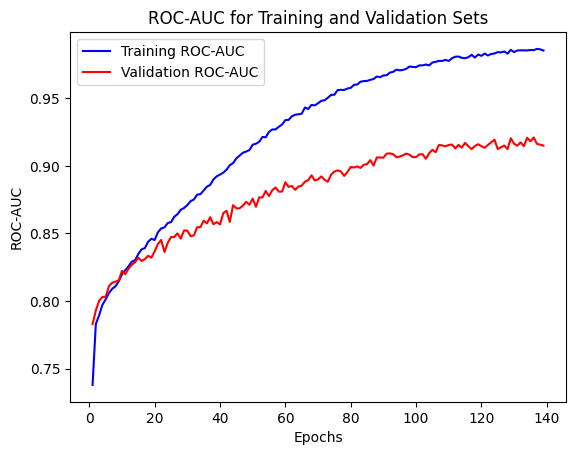

<Axes: >

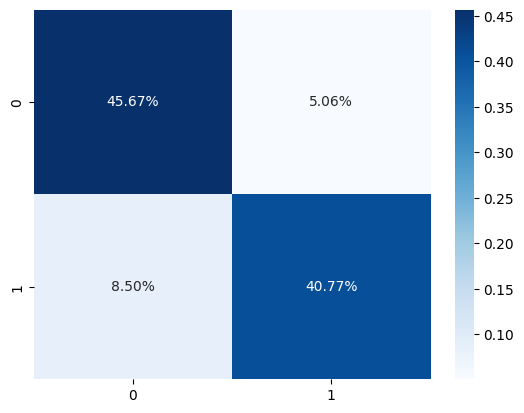

In [5]:
from keras.models import Model
from keras.layers import Dense, LSTM, Dropout, Input, concatenate
from keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score, accuracy_score
import matplotlib.pyplot as plt

dropout=0.05
lstm_units = 256
lstm_units2 = 128
dense_units = 64


# First branch for the LSTM
lstm_input = Input(shape=(1, 100))
lstm_output = LSTM(units=lstm_units, return_sequences=True, activation='relu')(lstm_input)
lstm_output = Dropout(dropout)(lstm_output)
lstm_output = LSTM(units=lstm_units2, activation='relu')(lstm_output)
lstm_output = Dropout(dropout)(lstm_output)

# Second branch for the dense layers
dense_input = Input(shape=(5,))
dense_output = Dense(units=dense_units, activation='relu')(dense_input)
dense_output = Dropout(dropout)(dense_output)

# Concatenate the outputs from both branches
combined = concatenate([lstm_output, dense_output])

combined = Dense(units = dense_units, activation='relu')(combined)

# Final output layer
output = Dense(units=1, activation='sigmoid')(combined)

# Create the model
model = Model(inputs=[lstm_input, dense_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Train the model with both LSTM and dense input
history = model.fit([X_train_vec, X_train], y_train, epochs=150, batch_size=64,
          validation_data=([X_test_vec, X_test], y_test),
          callbacks=[early_stopping])

# Predict and evaluate
y_pred = model.predict([X_test_vec, X_test])
roc_auc = roc_auc_score(y_test, y_pred)

y_pred_class = (y_pred > .5).astype(int)
accuracy = accuracy_score(y_test,y_pred_class)
print('ROC-AUC:', roc_auc)
print('Accuracy:', accuracy)

# Get the ROC-AUC values for training and validation sets
train_roc_auc = history.history['auc']
val_roc_auc = history.history['val_auc']

# Plot ROC-AUC for training and validation sets
epochs = range(1, len(train_roc_auc) + 1)

plt.plot(epochs, train_roc_auc, 'b', label='Training ROC-AUC')
plt.plot(epochs, val_roc_auc, 'r', label='Validation ROC-AUC')
plt.title('ROC-AUC for Training and Validation Sets')
plt.xlabel('Epochs')
plt.ylabel('ROC-AUC')
plt.legend()
plt.show()

from sklearn.metrics import confusion_matrix
import seaborn as sns

matrix = confusion_matrix(y_test, y_pred_class)

sns.heatmap(matrix/np.sum(matrix), annot=True, fmt='.2%', cmap='Blues')

In [6]:
import numpy as np
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec

#create extra variables for later
df_other_var = create_other_var(df)

#Create simple dataframe with only text and predictor
df = df[['Title','Political Lean']] 

#dummy code predictor
df['Political Lean'] = df['Political Lean'].replace('Liberal',1)
df['Political Lean'] = df['Political Lean'].replace('Conservative',0)

df = df.rename({'Political Lean':'y'},axis=1) #replace column name for simplicity

df = pd.concat([df,df_other_var],axis=1)

df = df[df['Length']>=15]

#Split into X & y
X = df.drop(['y'],axis=1)
y = df['y']

#oversample minority class
oversample = RandomOverSampler(sampling_strategy='minority', random_state=13)
X, y = oversample.fit_resample(X, y)
X, y = shuffle(X,y, random_state=13)

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X_train_text, X_test_text, y_train_text, y_test_text = train_test_split(X,y, test_size=.15, random_state = 13)

In [9]:
predictions = pd.DataFrame(y_pred, columns = ['prob'])
loss_df = pd.concat([X_test_text,predictions.set_index(X_test_text.index)],axis=1)
loss_df = pd.concat([loss_df,y_test_text],axis=1)
loss_df['prob'] = abs(loss_df['prob']-.5)

In [10]:
#dropping duplicates due to oversampling
pd.set_option('display.max_colwidth', None)
loss_df.drop_duplicates(subset='Title').sort_values(by='prob').tail(50)

,Title,Upvotes,Comments,Length,Capitals,prob,y
18153,Hillary's Revenge: Trump Promised Voters He Would Protect Classified Information,240,26,80,10,0.5,1
5880,Dems reveal $3.5T budget that sidesteps debt ceiling,219,14,52,1,0.5,1
15921,"Republicans are blaming Biden for letting a suspected Chinese spy balloon cross into the US. It happened 3 times during the Trump administration, officials say.",299,11,160,6,0.5,1
26701,"Joe and Hunter Biden caught on 17 recordings with Burisma owner, Grassley reveals FBI form says",29,2,95,6,0.5,0
20381,Parlatore: Not Surprising if No Charges for Trump,14,2,49,6,0.5,0
4014,"Plenty more to come, Boris",144,5,26,2,0.5,1
22884,"Trump talks about Putin, mocking Merkel and more at Mar-a-Lago",4,1,62,5,0.5,0
6115,Biden condemns 'selfishness' of stolen election lie pushed by Trump,375,58,67,2,0.5,1
22842,McCarthy Expects FBI To Share File On Biden Bribery Allegations,92,8,63,10,0.5,0
16377,McConnell says national abortion ban ‘possible’,175,40,47,1,0.5,1


In [11]:
#dropping duplicates due to oversampling
pd.set_option('display.max_colwidth', None)
loss_df.drop_duplicates(subset='Title').sort_values(by='prob').head(50)

,Title,Upvotes,Comments,Length,Capitals,prob,y
7924,"Syrian Chemical Weapons Attack, False Flag to Promote U.S. Intervention",3,1,71,8,0.000294,1
5013,America is doomed,156,10,17,1,0.000738,1
14054,The public has a right to see the Nashville shooter’s writings,33,2,62,2,0.001996,0
26193,For my fellow Catholics here,28,4,28,2,0.002002,0
6296,"Undercover GOP operatives trained by former spies infiltrated liberal groups to try and compromise them from the inside, report says",8,0,132,2,0.002533,1
6670,"Opinion | A New Deal, This Time for Everyone",11,0,44,6,0.003209,1
9,Workers Behind First Union Push at an Amazon Retail Store Want $25/hr,19,0,69,9,0.003542,1
2895,Why is infighting so widespread among the Left compared to the Right?,5,12,69,3,0.004003,1
20838,‘Bombshell’ New Report Suggests Bill Gates Was Caught in Epstein Blackmail Scheme with Russian Woman,186,23,100,13,0.005023,0
10170,Ted Cruz asks if civil liberties groups will support Canadian freedom truckers as they clash with police,9,1,104,3,0.006044,0
